---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>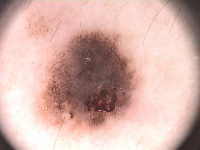</td><td>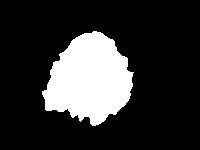</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [1]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

d:\Anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [2]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [3]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [4]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

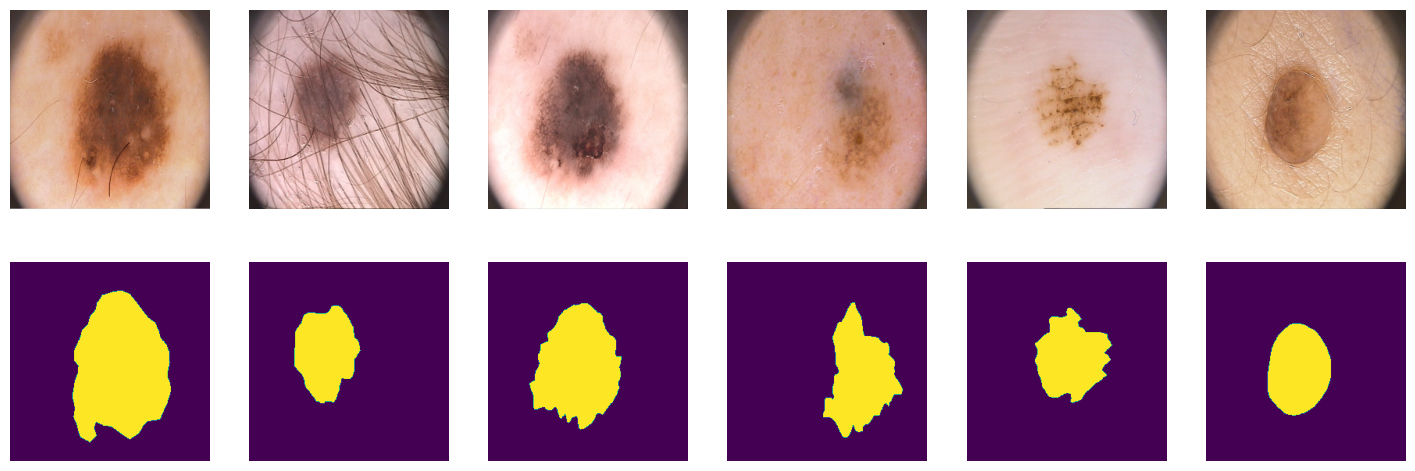

In [5]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [6]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [7]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [8]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [9]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

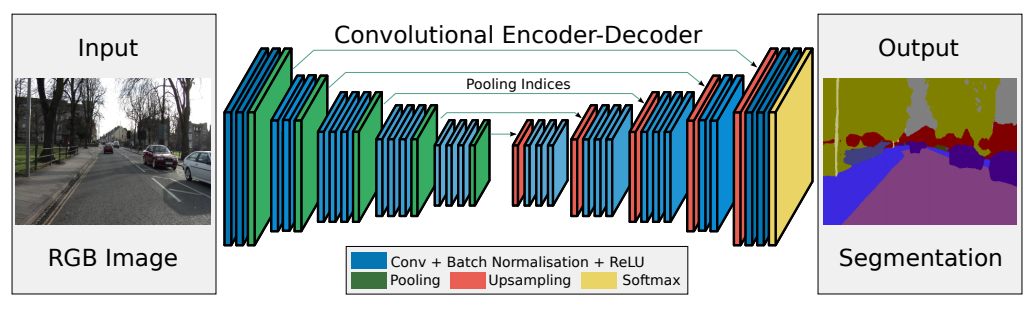

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [11]:
class ConvNormBlock(nn.Module):
    def __init__(self, in_channels, out_channels, is_last_block=False):
        super().__init__()
        self.is_last_block = is_last_block
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if not self.is_last_block:
            x = self.relu(x)
        return x

In [12]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        #channels = 16
        self.enc_conv0 = ConvNormBlock(3, 16)
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True)  # 256 -> 128
        self.enc_conv1 = ConvNormBlock(16, 32)
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True) # 128 -> 64
        self.enc_conv2 = ConvNormBlock(32, 64)
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True) # 64 -> 32
        self.enc_conv3 = ConvNormBlock(64, 128)
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = ConvNormBlock(128, 128)

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv0 = ConvNormBlock(128, 64)

        self.upsample1 = nn.MaxUnpool2d(2, 2) # 32 -> 64
        self.dec_conv1 = ConvNormBlock(64, 32)

        self.upsample2 = nn.MaxUnpool2d(2, 2)  # 64 -> 128
        self.dec_conv2 = ConvNormBlock(32, 16)
        
        self.upsample3 = nn.MaxUnpool2d(2, 2)  # 128 -> 256
        self.dec_conv3 = ConvNormBlock(16, 1, is_last_block=True)

    def forward(self, x):
        # encoder
        e, poll_ind0 = self.pool0(self.enc_conv0(x))
        e, poll_ind1 = self.pool1(self.enc_conv1(e))
        e, poll_ind2 = self.pool2(self.enc_conv2(e))
        e, poll_ind3 = self.pool3(self.enc_conv3(e))

        # bottleneck <1>
        b = self.bottleneck_conv(e)
        
        # decoder
        d = self.dec_conv0(self.upsample0(b, indices=poll_ind3))
        d = self.dec_conv1(self.upsample1(d, indices=poll_ind2))
        d = self.dec_conv2(self.upsample2(d, indices=poll_ind1))
        d = self.dec_conv3(self.upsample3(d, indices=poll_ind0))  # no activation
        return torch.sigmoid(d)

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [13]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
     
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()

    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    #print(iou)

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded  #

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации.

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [14]:
def bce_loss(y_real, y_pred):
    # TODO
    # please don't use nn.BCELoss. write it from scratch
    loss = y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred))
    
    # Усредняем потери по всем примерам
    loss = torch.mean(loss)
    
    return loss

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [48]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, show_plots=True):
    losses = []
    val_acc = []
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device) 
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)
        losses.append(loss)

        # show intermediate results
        model.eval()  # testing mode
        with torch.no_grad():
            Y_hat = model(X_val.to(device)).cpu().detach()


        # Visualize tools
        if show_plots:
            clear_output(wait=True)
            for k in range(6):
                plt.subplot(4, 6, k+1)
                plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
                plt.title('Real')
                plt.axis('off')

                plt.subplot(4, 6, k+7)
                plt.imshow(Y_hat[k, 0], cmap='gray')
                plt.title('Pred')
                plt.axis('off')

                plt.subplot(4, 6, k+13)
                plt.imshow(Y_val[k, 0], cmap='gray')
                plt.title('True')
                plt.axis('off')

                plt.subplot(4, 6, k+19)
                plt.imshow(Y_val[k, 0].byte() & Y_hat[k, 0].byte(), cmap='gray')
                plt.title('Intersec')
                plt.axis('off')
            #plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
            plt.show()
        
        val_score = score_model(model, iou_pytorch, data_val, show_plots=False)
        print('val score', val_score)
        val_acc.append(val_score)
        #print('val_acc', val_acc)
    return losses, val_acc

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [16]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [17]:
def score_model(model, metric, data, treshold=0.5, show_plots=True):
    #3#
    X_val, Y_val = next(iter(data))
    model.eval()  # testing mode
    with torch.no_grad():
        Y_hat = model(X_val.to(device)).cpu().detach()

    Y_hat = Y_hat > 0.5

    if show_plots:
    # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(4, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(4, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Pred')
            plt.axis('off')

            plt.subplot(4, 6, k+13)
            plt.imshow(Y_val[k, 0], cmap='gray')
            plt.title('True')
            plt.axis('off')

            plt.subplot(4, 6, k+19)
            plt.imshow(Y_val[k, 0].byte() & Y_hat[k, 0].byte(), cmap='gray')
            plt.title('Intersec')
            plt.axis('off')
        #plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
    #3#
    model.eval()  # переводим модель в режим тестирования
    scores = 0
    with torch.no_grad():
        for X_batch, Y_label in data:
            # Отправляем данные на устройство (GPU, если доступно)
            X_batch = X_batch.to(device)
            Y_label = Y_label.to(device)
            # Прямой проход (forward pass) для получения предсказаний
            Y_pred = model(X_batch) > treshold # treshold to binarize matrix

            # Вычисляем метрику на текущем батче и суммируем
        
            scores += metric(Y_label, Y_pred).mean().item()

    # Возвращаем усредненную метрику по всем батчам
    return scores / len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [18]:
model = SegNet().to(device)

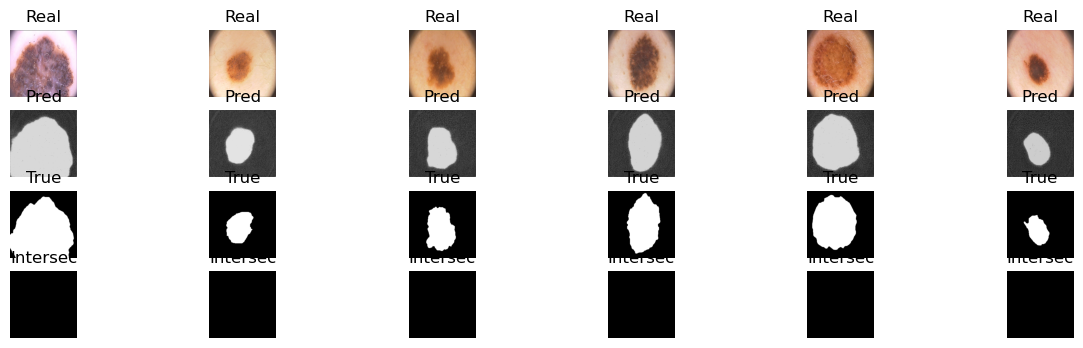

In [20]:
max_epochs = 20
optim = torch.optim.Adam(model.parameters(), lr=3e-4)
train(model, optim, bce_loss, max_epochs, data_tr, data_val)
None

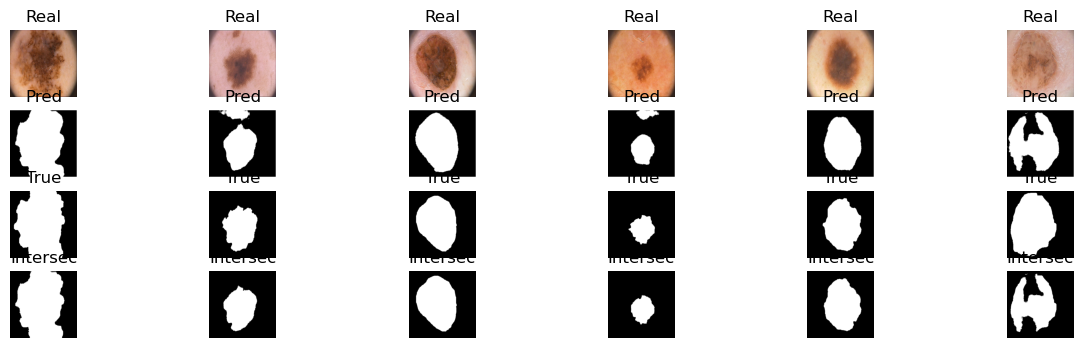

0.6779999732971191

In [97]:
score_model(model, iou_pytorch, data_val)
# я добавил treshold для score_model иначе она ыдавала 0 тк для сравнения нужны бинарные матрицы 

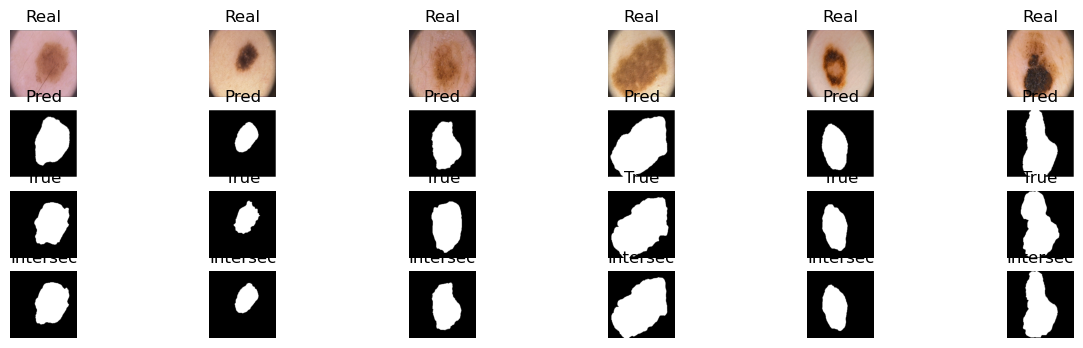

0.6840000152587891

In [98]:
score_model(model, iou_pytorch, data_ts)

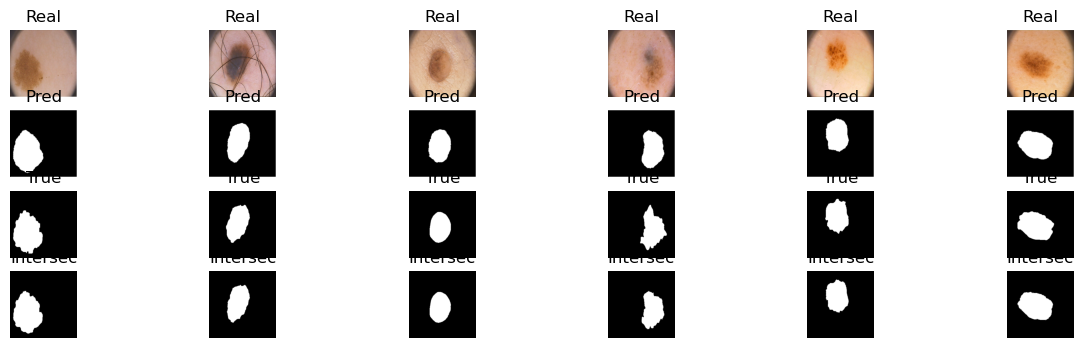

0.7729999870061874

In [99]:
score_model(model, iou_pytorch, data_tr)

Ответьте себе на вопрос: не переобучается ли моя модель?

Исходя из изображений выше, можно сказать, что модель нормально работает на val и test выборках, но все же не идеально.  
Однако на train выборке результат лучше почти на 0.1 

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла]

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [21]:
def dice_loss(y_real, y_pred):
    smooth =  1e-8
    num = 2 * (y_real * y_pred).sum()
    den = y_real.sum() + y_pred.sum()
    res = 1 - 1/(256*256) * ((num + smooth) / (den + smooth))
    return res

Проводим тестирование:

In [ ]:
model_dice = SegNet().to(device)

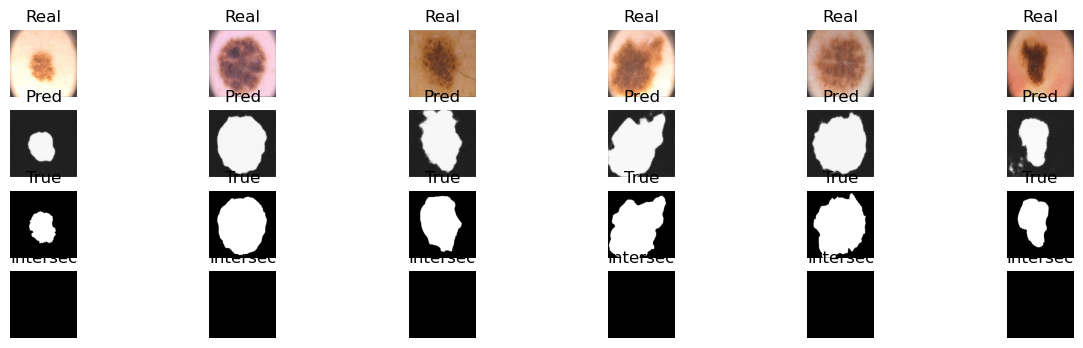

In [116]:

max_epochs = 40
optimaizer = torch.optim.Adam(model_dice.parameters())
train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

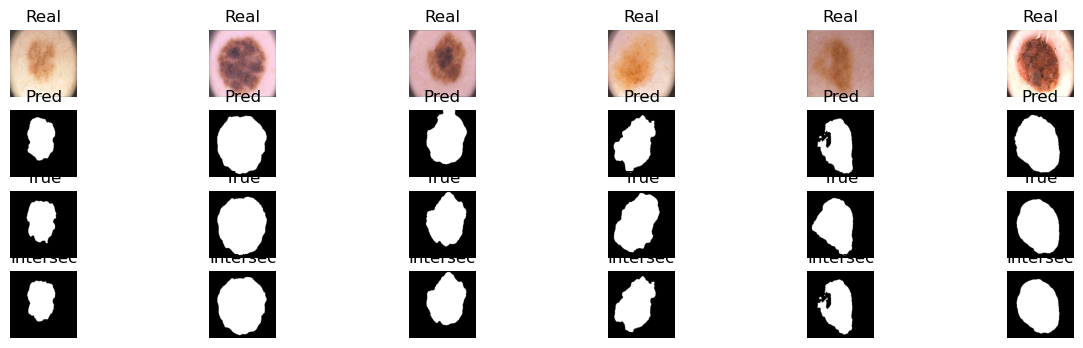

0.75

In [117]:
score_model(model_dice, iou_pytorch, data_val)

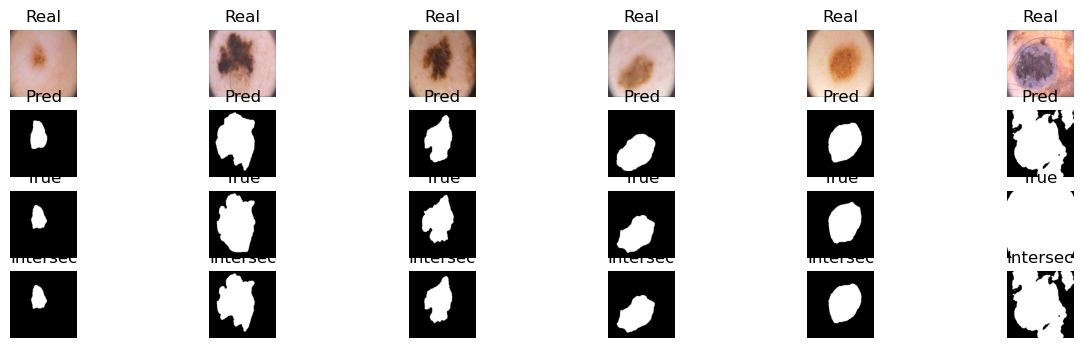

0.7139999866485596

In [121]:
score_model(model_dice, iou_pytorch, data_ts)

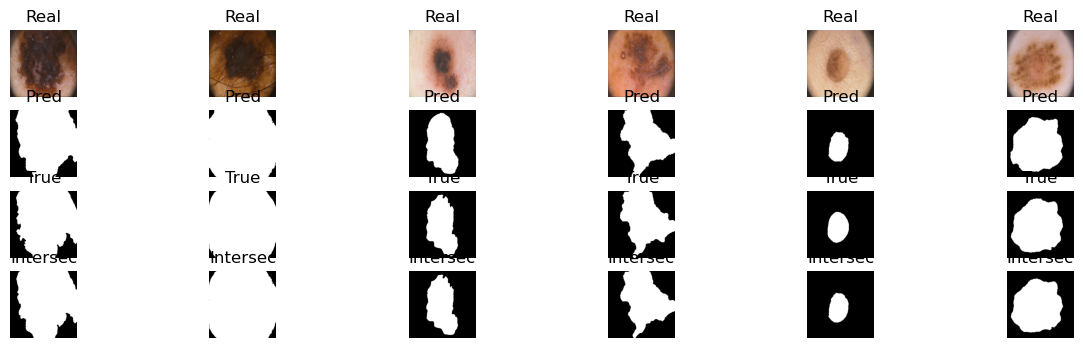

0.9050000309944153

In [122]:
score_model(model_dice, iou_pytorch, data_tr)

Дважды прогнал модель - суммарно 40*2= 80 эпох  
На test стало лучше на ~3 процента 
Исходя из результатов на train можно сказать что модель переобучилась тк разница составляет ~20. Возможно сама модель слишком вместительная и ее надо урезать  

пора попробовать упрощенную модель:

In [18]:
class SimpleConvNormBlock(nn.Module):
    def __init__(self, in_channels, out_channels, is_last_block=False):
        super().__init__()
        self.is_last_block = is_last_block
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        
        if not self.is_last_block:
            x = self.relu(x)
        return x

In [19]:
class SimpleSegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        #channels = 16
        self.enc_conv0 = SimpleConvNormBlock(3, 16)
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True)  # 256 -> 128
        self.enc_conv1 = SimpleConvNormBlock(16, 32)
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True) # 128 -> 64
        self.enc_conv2 = SimpleConvNormBlock(32, 64)
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True) # 64 -> 32
        self.enc_conv3 = SimpleConvNormBlock(64, 128)
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = SimpleConvNormBlock(128, 128)

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv0 = SimpleConvNormBlock(128, 64)

        self.upsample1 = nn.MaxUnpool2d(2, 2) # 32 -> 64
        self.dec_conv1 = SimpleConvNormBlock(64, 32)

        self.upsample2 = nn.MaxUnpool2d(2, 2)  # 64 -> 128
        self.dec_conv2 = SimpleConvNormBlock(32, 16)
        
        self.upsample3 = nn.MaxUnpool2d(2, 2)  # 128 -> 256
        self.dec_conv3 = SimpleConvNormBlock(16, 1, is_last_block=True)

    def forward(self, x):
        # encoder
        e, poll_ind0 = self.pool0(self.enc_conv0(x))
        e, poll_ind1 = self.pool1(self.enc_conv1(e))
        e, poll_ind2 = self.pool2(self.enc_conv2(e))
        e, poll_ind3 = self.pool3(self.enc_conv3(e))

        # bottleneck <1>
        b = self.bottleneck_conv(e)
        
        # decoder
        d = self.dec_conv0(self.upsample0(b, indices=poll_ind3))
        d = self.dec_conv1(self.upsample1(d, indices=poll_ind2))
        d = self.dec_conv2(self.upsample2(d, indices=poll_ind1))
        d = self.dec_conv3(self.upsample3(d, indices=poll_ind0))  # no activation
        return torch.sigmoid(d)

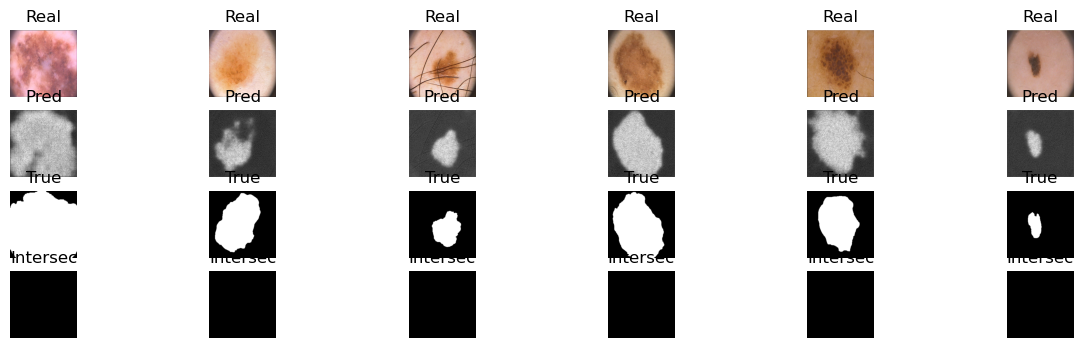

In [142]:
simple_seg_model = SimpleSegNet().to(device)
max_epochs = 20
optim = torch.optim.Adam(simple_seg_model.parameters(), lr=3e-4)
train(simple_seg_model, optim, bce_loss, max_epochs, data_tr, data_val)

In [143]:
val_score = score_model(simple_seg_model, iou_pytorch, data_val, show_plots=False)
test_score = score_model(simple_seg_model, iou_pytorch, data_ts, show_plots=False)
train_score = score_model(simple_seg_model, iou_pytorch, data_tr, show_plots=False)

print('validation score', val_score)
print('test score', test_score)
print('train score', train_score)

validation score 0.636000007390976
test score 0.6579999625682831
train score 0.7189999669790268


Стало немного хуже 

Теперь для дайс

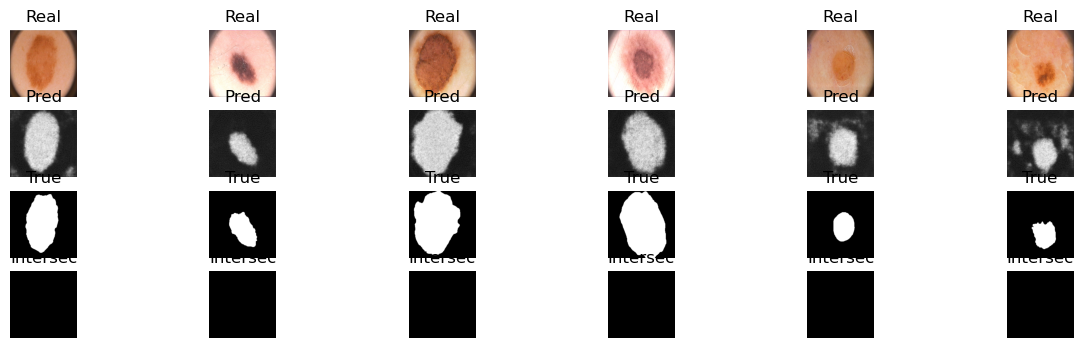

In [135]:
simple_dice_seg_model = SimpleSegNet().to(device)
max_epochs = 40
optimaizer = torch.optim.Adam(simple_dice_seg_model.parameters())
train(simple_dice_seg_model, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [139]:
val_score = score_model(simple_dice_seg_model, iou_pytorch, data_val, show_plots=False)
test_score = score_model(simple_dice_seg_model, iou_pytorch, data_ts, show_plots=False)
train_score = score_model(simple_dice_seg_model, iou_pytorch, data_tr, show_plots=False)

print('validation score', val_score)
print('test score', test_score)
print('train score', train_score)

validation score 0.637999951839447
test score 0.6300000250339508
train score 0.7219999879598618


Тоже стало хуже  
Гипотеза не подтвердилась 

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [22]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):

    summand1 = torch.pow((1 - y_pred), gamma) * y_real * torch.log(y_pred + eps)
    summand2 = (1 - y_pred) * torch.log(1 - y_pred + eps)
    
    loss = -torch.sum(summand1 + summand2) / y_pred.size(0)
    #y_pred =  # hint: torch.clamp # чет я не понял зачем это, но когда словлю ошибку пойму
    #print(summand1)
    #print(summand2)
    return loss


In [23]:


class FocalLoss:
    def __init__(self, gamma = 2):
        self.gamma = gamma
    def __call__(self, y_real, y_pred):
         
        return focal_loss(y_real, y_pred, gamma=self.gamma)

In [61]:
model_focal = SegNet().to(device)

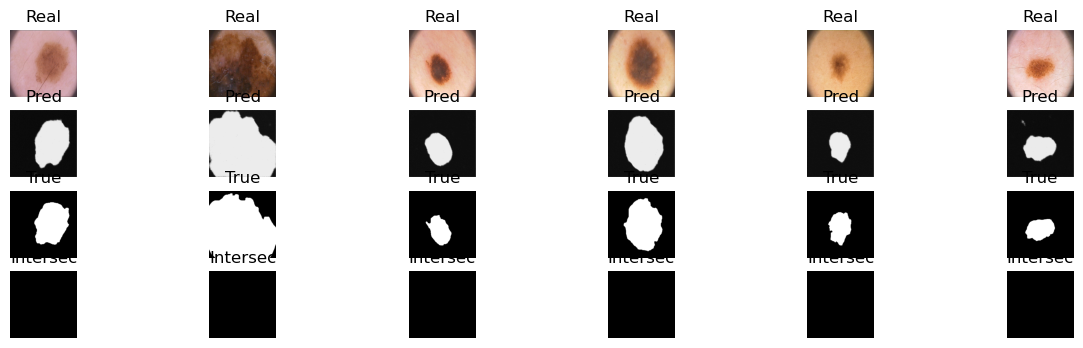

validation score 0.6880000233650208
val_acc [0.10200000368058681, 0.10199999809265137, 0.10200000554323196, 0.10199999436736107, 0.10200000181794167, 0.10199999436736107, 0.10199999436736107, 0.09800000488758087, 0.09800000116229057, 0.10999999940395355, 0.12199999392032623, 0.12600000575184822, 0.14799999818205833, 0.16999999433755875, 0.20400001108646393, 0.23599999397993088, 0.2759999930858612, 0.3179999887943268, 0.32600001990795135, 0.3239999860525131, 0.3439999967813492, 0.3660000115633011, 0.35999996960163116, 0.4519999921321869, 0.5259999632835388, 0.5399999916553497, 0.46400000154972076, 0.4919999837875366, 0.4919999688863754, 0.5499999821186066, 0.4899999797344208, 0.414000004529953, 0.3659999966621399, 0.4479999840259552, 0.39799998700618744, 0.43400000035762787, 0.4960000067949295, 0.4559999853372574, 0.43199998140335083, 0.5360000282526016, 0.6399999856948853, 0.5739999711513519, 0.6080000102519989, 0.5620000064373016, 0.43400000035762787, 0.4659999907016754, 0.59799998998

In [62]:

max_epochs = 150     
optimaizer = optim.Adam(model_focal.parameters(), lr=3e-4)
losses, val_acc = train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val, show_plots=True)

 при гаммма = 2 : 40 итераций маловато добавлю еще 40+120+400+120
где то около 4000 +-400 лосс и дальше не идет 
И итог 0,47 на  - явное переобучение
  
+ если обучить только на 120ти эпохаха то тест уже 0.7 при значении на трейне 0.77   
+ обучение только на 400  - неплохие результаты + переобучение: test 0.73 train=0.97. Надо попробовать остановить раньше
+ 150 эпох test 0.69, train 0.82

при гамма = 4  
+ 150 эпох test 0.73, train 0.88  
при гамма = 6  
+ 150 эпох test 0.16, train 0.21  
при гамма = 1.5  
+ 150 эпох test 0.75, train 0.84  
при гамма = 1.3  
+ 150 эпох test 0.67, train 0.79  



In [24]:
import matplotlib.pyplot as plt
def show_plot(data: torch.Tensor, title: str, xlabel: str, ylabel: str):
    for i in range(len(data)):
        data[i] = float(data[i])
    
    plt.plot(data)
    # Добавляем заголовок и метки осей
    plt.title('title')
    plt.xlabel('xlabel')
    plt.ylabel('ylabel')

    # Отображаем график
    plt.show()

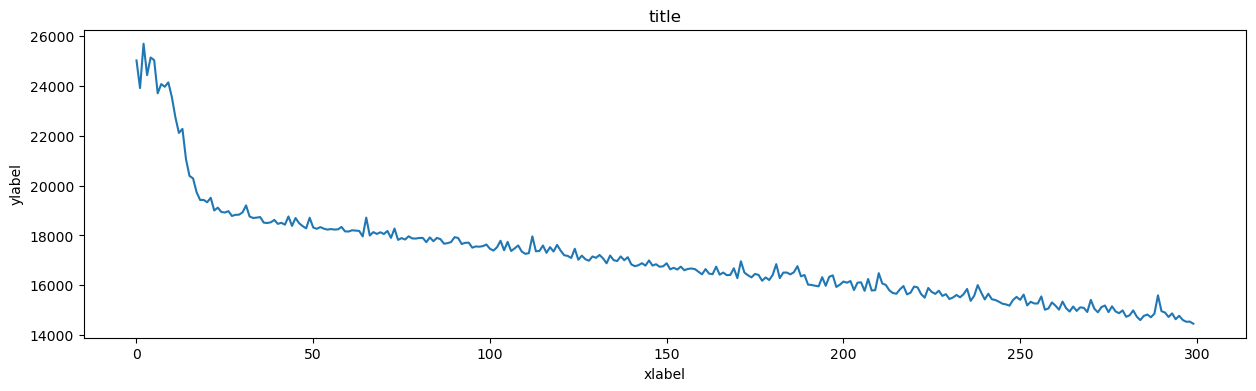

In [58]:
show_plot(losses, title='Лосы', xlabel='Эпоха', ylabel='Лосы')

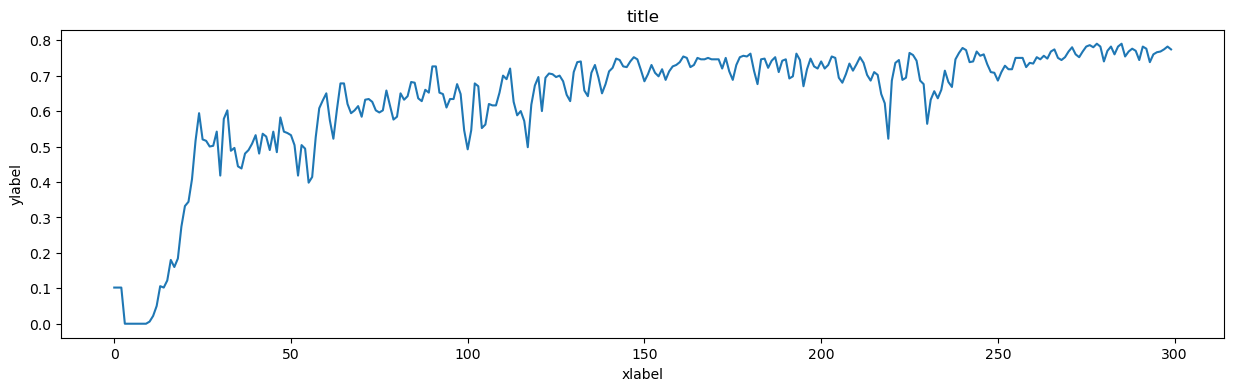

In [59]:
show_plot(val_acc, title='focal Точность на валидации', xlabel='Эпоха', ylabel='точность')

Можно попробовать 150 эпох, как видно из графика 150

тк ложно негативные штрафуются сильнее то модель склонна выделять области большего размера, возможно имеет смысл подобрать гамму

In [64]:
val_score = score_model(model_focal, iou_pytorch, data_val, show_plots=False)
test_score = score_model(model_focal, iou_pytorch, data_ts, show_plots=False)
train_score = score_model(model_focal, iou_pytorch, data_tr, show_plots=False)

print('validation score', val_score)
print('test score', test_score)
print('train score', train_score)

validation score 0.6879999935626984
test score 0.69200000166893
train score 0.8250000029802322


гамма=4

In [68]:
model_focal_4 = SegNet().to(device)
foc_los = FocalLoss(gamma=4)

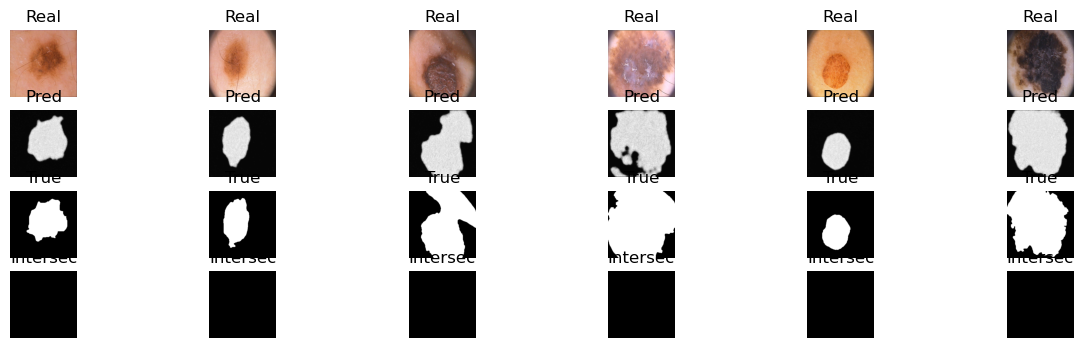

val_acc [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08200000040233135, 0.33400001376867294, 0.431999996304512, 0.4320000112056732, 0.4959999918937683, 0.5299999713897705, 0.5360000133514404, 0.5300000011920929, 0.5619999766349792, 0.4520000070333481, 0.48600001633167267, 0.5460000038146973, 0.5320000052452087, 0.5579999834299088, 0.5180000066757202, 0.5439999997615814, 0.5720000267028809, 0.6240000128746033, 0.637999951839447, 0.47199998795986176, 0.5119999945163727, 0.5960000157356262, 0.5980000197887421, 0.6239999830722809, 0.543999969959259, 0.5220000296831131, 0.5180000066757202, 0.5760000050067902, 0.6220000088214874, 0.5839999914169312, 0.6260000169277191, 0.6660000085830688, 0.664000004529953, 0.6620000004768372, 0.6419999897480011, 0.6800000369548798, 0.6600000262260437, 0.6899999976158142, 0.7119999825954437, 0.4620000123977661, 0.5799999833106995, 0.6019999980926514, 0.5919999778270721, 0.5279999673366547, 0.5299999713897705, 0.6500000059604645, 0.6840000152587891, 0

In [69]:

max_epochs = 150     
optimaizer = optim.Adam(model_focal_4.parameters(), lr=3e-4)
losses, val_acc = train(model_focal_4, optimaizer, foc_los, max_epochs, data_tr, data_val, show_plots=True)

In [71]:
val_score = score_model(model_focal_4, iou_pytorch, data_val, show_plots=False)
test_score = score_model(model_focal_4, iou_pytorch, data_ts, show_plots=False)
train_score = score_model(model_focal_4, iou_pytorch, data_tr, show_plots=False)

print('validation score', val_score)
print('test score', test_score)
print('train score', train_score)

validation score 0.7300000190734863
test score 0.7379999756813049
train score 0.8890000134706497


Вроде неплохо получилось

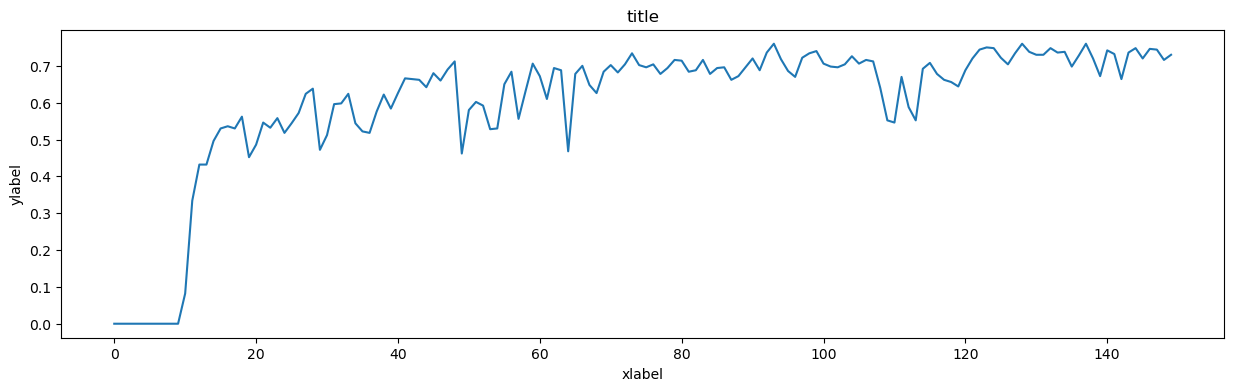

In [72]:
show_plot(val_acc, title='focal Точность на валидации', xlabel='Эпоха', ylabel='точность')

Гамма = 6

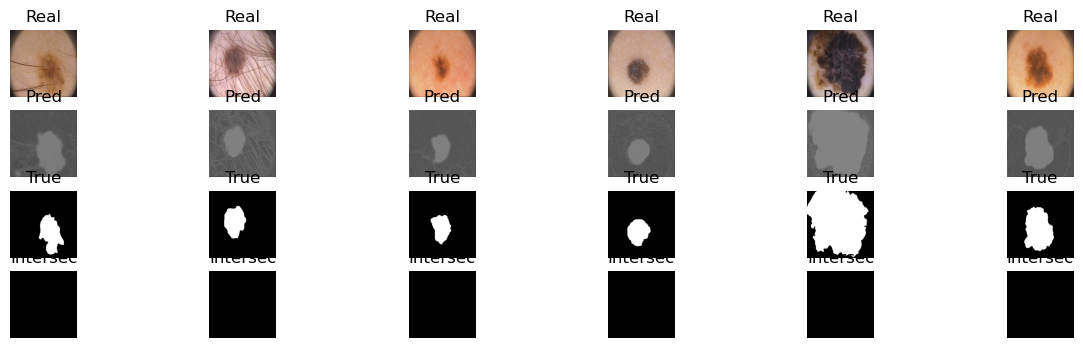

val_acc [0.10200000181794167, 0.10200000554323196, 0.10200000181794167, 0.10200000181794167, 0.10000000149011612, 0.08999999985098839, 0.07000000402331352, 0.05400000140070915, 0.03600000194273889, 0.015999999828636646, 0.011999999871477485, 0.011999999871477485, 0.012000000569969416, 0.00800000037997961, 0.00800000037997961, 0.006000000052154064, 0.014000000432133675, 0.026000000070780516, 0.03600000124424696, 0.06399999931454659, 0.04399999976158142, 0.0560000017285347, 0.052000002935528755, 0.06999999471008778, 0.06800000183284283, 0.07800000160932541, 0.06999999843537807, 0.06799999624490738, 0.07200000062584877, 0.04400000162422657, 0.07800000160932541, 0.08999999798834324, 0.10200000181794167, 0.10399999842047691, 0.1120000071823597, 0.10400000214576721, 0.1080000028014183, 0.10199999436736107, 0.09799999743700027, 0.1120000034570694, 0.1119999997317791, 0.107999999076128, 0.12400000169873238, 0.1119999997317791, 0.12400000169873238, 0.10399999842047691, 0.11000000685453415, 0.11

In [75]:
model_focal_6 = SegNet().to(device)
foc_los = FocalLoss(gamma=6)
max_epochs = 150     
optimaizer = optim.Adam(model_focal_6.parameters(), lr=3e-4)
losses, val_acc = train(model_focal_6, optimaizer, foc_los, max_epochs, data_tr, data_val, show_plots=True)

In [77]:
val_score = score_model(model_focal_6, iou_pytorch, data_val, show_plots=False)
test_score = score_model(model_focal_6, iou_pytorch, data_ts, show_plots=False)
train_score = score_model(model_focal_6, iou_pytorch, data_tr, show_plots=False)

print('validation score', val_score)
print('test score', test_score)
print('train score', train_score)

validation score 0.14999999850988388
test score 0.1679999977350235
train score 0.21799999475479126


In [ ]:
Увы

Гамма = 1.5

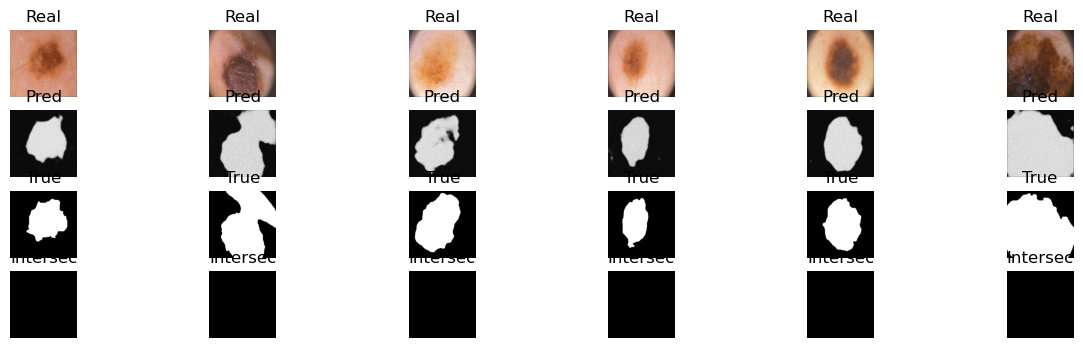

val_acc [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12999999523162842, 0.41200000047683716, 0.49399998784065247, 0.5379999876022339, 0.5759999752044678, 0.5080000162124634, 0.5960000455379486, 0.6040000021457672, 0.5319999754428864, 0.42800000309944153, 0.4700000286102295, 0.5540000200271606, 0.5739999711513519, 0.5660000145435333, 0.5439999997615814, 0.6499999761581421, 0.7039999961853027, 0.5740000009536743, 0.6099999845027924, 0.6399999856948853, 0.601999968290329, 0.5699999779462814, 0.5740000009536743, 0.5460000038146973, 0.6360000669956207, 0.6559999585151672, 0.6259999871253967, 0.656000018119812, 0.6919999718666077, 0.6240000128746033, 0.6439999639987946, 0.7019999325275421, 0.6759999990463257, 0.6839999556541443, 0.6179999709129333, 0.6119999885559082, 0.7099999785423279, 0.6940000057220459, 0.6239999830722809, 0.5779999792575836, 0.6559999585151672, 0.6939999759197235, 0.706000030040741, 0.679999977350235, 0.7459999918937683, 0.5900000035762787, 0.5820000171661377, 0.5359

In [78]:
model_focal_15 = SegNet().to(device)
foc_los = FocalLoss(gamma=1.5)
max_epochs = 150     
optimaizer = optim.Adam(model_focal_15.parameters(), lr=3e-4)
losses, val_acc = train(model_focal_15, optimaizer, foc_los, max_epochs, data_tr, data_val, show_plots=True)

val_score = score_model(model_focal_15, iou_pytorch, data_val, show_plots=False)
test_score = score_model(model_focal_15, iou_pytorch, data_ts, show_plots=False)
train_score = score_model(model_focal_15, iou_pytorch, data_tr, show_plots=False)

print('validation score', val_score)
print('test score', test_score)
print('train score', train_score)

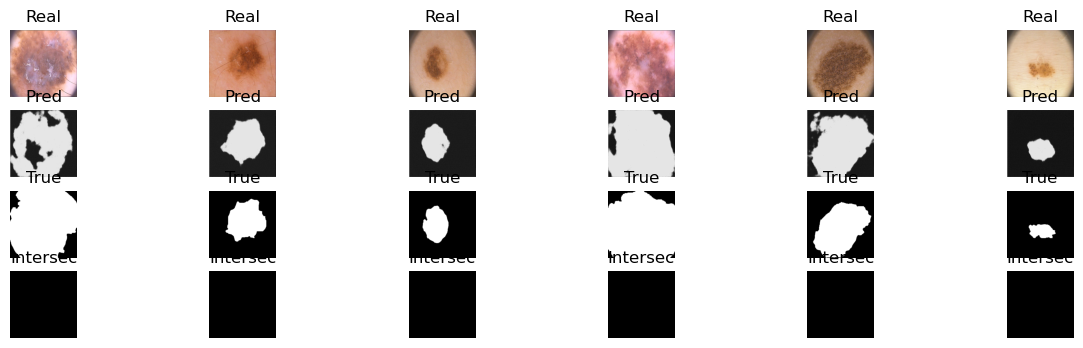

validation score 0.6520000100135803
test score 0.6759999990463257
train score 0.79100002348423


In [80]:
model_focal_13 = SegNet().to(device)
foc_los = FocalLoss(gamma=1.3)
max_epochs = 150     
optimaizer = optim.Adam(model_focal_13.parameters(), lr=3e-4)
losses, val_acc = train(model_focal_13, optimaizer, foc_los, max_epochs, data_tr, data_val, show_plots=True)

val_score = score_model(model_focal_13, iou_pytorch, data_val, show_plots=False)
test_score = score_model(model_focal_13, iou_pytorch, data_ts, show_plots=False)
train_score = score_model(model_focal_13, iou_pytorch, data_tr, show_plots=False)

print('validation score', val_score)
print('test score', test_score)
print('train score', train_score)

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты?

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

тк нам нужны логиты, то нужно немного поменять код класса SegNet

In [24]:

def total_variation(image):
    """
    Вычисляет Total Variation (TV) на изображении.

    Args:
        image (torch.Tensor): Изображение, представленное в виде тензора (batch_size, channels, height, width).

    Returns:
        torch.Tensor: Значение Total Variation.
    """
    # Вычисляем разницу между соседними пикселями по горизонтали и вертикали
    horizontal_diff = image[:, :, :, :-1] - image[:, :, :, 1:]
    vertical_diff = image[:, :, :-1, :] - image[:, :, 1:, :]

    # Суммируем абсолютные значения разницы
    tv = torch.sum(torch.abs(horizontal_diff)) + torch.sum(torch.abs(vertical_diff))

    return tv

In [46]:


class LossPlusTV:
    def __init__(self, loss_func, alpha_loss, alpha_tv):
        self.loss = loss_func
        self.alpha_loss = alpha_loss
        self.alpha_tv = alpha_tv

    def __call__(self, y_real, y_pred):
        loss = self.loss(y_real=y_real, y_pred=y_pred)
        tv = total_variation(y_pred)
        #print('loss', self.alpha_loss * loss)
        #print('tv', self.alpha_tv*tv)
        return self.alpha_loss * loss + self.alpha_tv * tv
        

In [ ]:
def dice_loss(y_real, y_pred):
    smooth =  1e-8
    num = 2 * (y_real * y_pred).sum()
    den = y_real.sum() + y_pred.sum()
    res = 1 - 1/(256*256) * ((num + smooth) / (den + smooth))
    return res

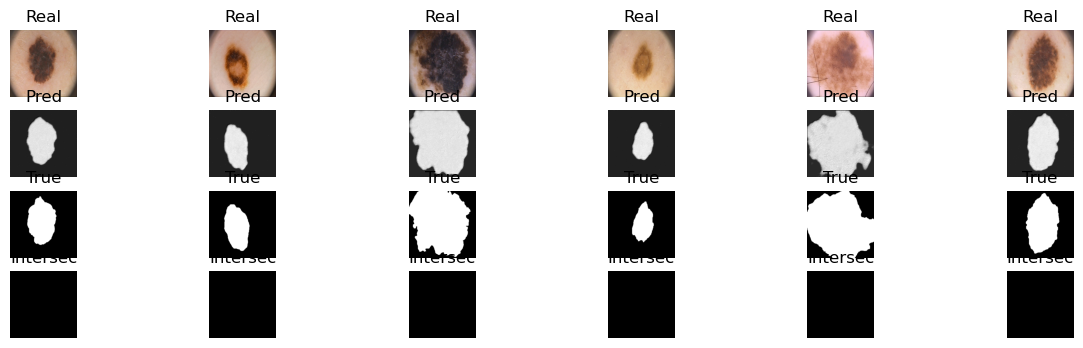

validation score 0.7580000162124634
test score 0.7719999849796295
train score 0.9689999967813492


In [44]:
model_dice_tv = SegNet().to(device)
dice_tv_los = LossPlusTV(bce_loss, alpha_loss=5, alpha_tv=0.000_000_1)
max_epochs = 150     
optimaizer = torch.optim.Adam(model_dice_tv.parameters(), lr=3e-4)
losses, val_acc = train(model_dice_tv, optimaizer, dice_tv_los, max_epochs, data_tr, data_val, show_plots=True)

val_score = score_model(model_dice_tv, iou_pytorch, data_val, show_plots=False)
test_score = score_model(model_dice_tv, iou_pytorch, data_ts, show_plots=False)
train_score = score_model(model_dice_tv, iou_pytorch, data_tr, show_plots=False)

print('validation score', val_score)
print('test score', test_score)
print('train score', train_score)

Лучший результат на тесте 0.77 предыдущий 0.75 - скорее погрешность

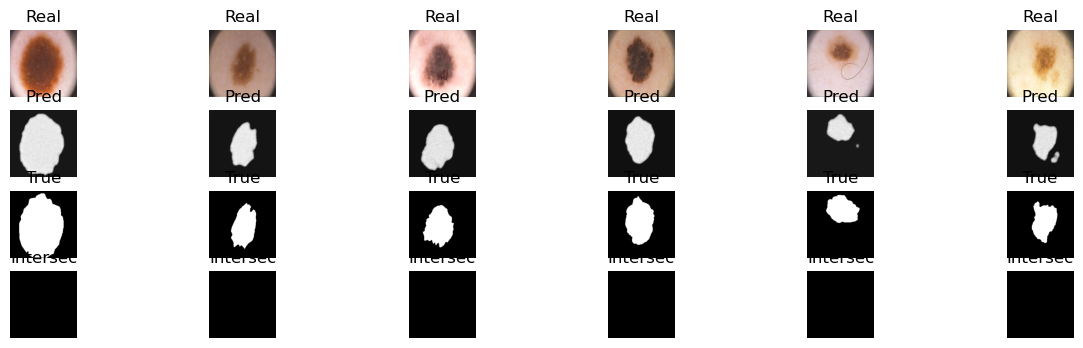

validation score 0.7500000298023224
test score 0.7479999959468842
train score 0.9570000022649765


In [47]:
model_dice_tv = SegNet().to(device)
dice_tv_los = LossPlusTV(bce_loss, alpha_loss=1, alpha_tv=0.000_000_1)
max_epochs = 150     
optimaizer = torch.optim.Adam(model_dice_tv.parameters(), lr=3e-4)
losses, val_acc = train(model_dice_tv, optimaizer, dice_tv_los, max_epochs, data_tr, data_val, show_plots=True)

val_score = score_model(model_dice_tv, iou_pytorch, data_val, show_plots=False)
test_score = score_model(model_dice_tv, iou_pytorch, data_ts, show_plots=False)
train_score = score_model(model_dice_tv, iou_pytorch, data_tr, show_plots=False)

print('validation score', val_score)
print('test score', test_score)
print('train score', train_score)

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

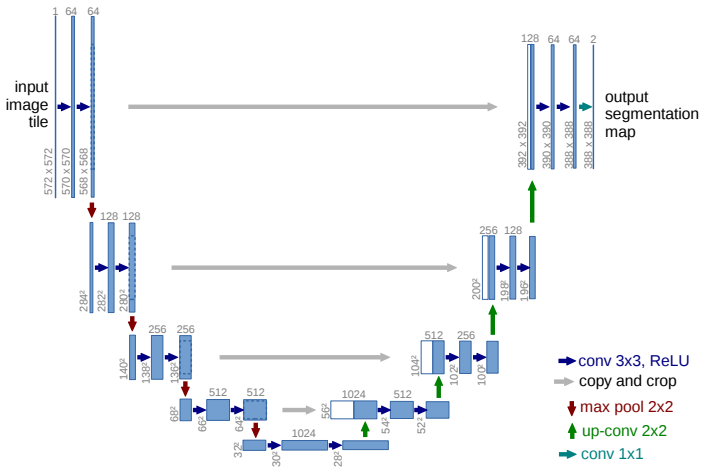

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 =
        self.pool0 =   # 256 -> 128
        self.enc_conv1 =
        self.pool1 =  # 128 -> 64
        self.enc_conv2 =
        self.pool2 =  # 64 -> 32
        self.enc_conv3 =
        self.pool3 =  # 32 -> 16

        # bottleneck
        self.bottleneck_conv =

        # decoder (upsampling)
        self.upsample0 =  # 16 -> 32
        self.dec_conv0 =
        self.upsample1 =  # 32 -> 64
        self.dec_conv1 =
        self.upsample2 =   # 64 -> 128
        self.dec_conv2 =
        self.upsample3 =   # 128 -> 256
        self.dec_conv3 =

    def forward(self, x):
        # encoder
        e0 =
        e1 =
        e2 =
        e3 =

        # bottleneck
        b =

        # decoder
        d0 =
        d1 =
        d2 =
        d3 =   # no activation
        return d3

In [ ]:
unet_model = UNet().to(device)

In [ ]:
train(unet_model, optim.Adam(unet_model.parameters()), bce_loss, 20, data_tr, data_val)

In [ ]:
score_model(unet_model, iou_pytorch, data_val)

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
class UNet2(nn.Module):


In [ ]:
unet2_model = UNet2().to(device)


In [ ]:
train(unet2_model, optim.Adam(unet2_model.parameters()), bce_loss, 5, data_tr, data_val)

Сделайте вывод, какая из моделей лучше

# Отчет (6 баллов):
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте.
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии:

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.